In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



Do checkout my previous notebook on this month's playground series - [EDA & Optuna with GPU](https://www.kaggle.com/jaikr18/tps-sept-detailed-eda-optuna-with-gpu-support), wherein I focused on EDA and trained optimized models for XGBClassifier, CatBoostClassifier, and LGBMClassifier. In this notebook, I will tackle the same problem with a neural network approach.

# **PROBLEM STATEMENT**

We are given the following:

1. A train dataset (.csv) containing the index column (0 to n_train_examples-1), features ('f1' to 'f118') and the ground truth *claim* (0 or 1) respectively.
2. A test dataset (.csv) containing the index column (0 to n_test_examples-1), features ('f1' to 'f118') respectively.

We are required to implement a binary-classification algorithm which predicts for each example of the test dataset, whether a customer made a claim upon an insurance policy. A '1' value means a claim was made, and '0' means a claim was not made.

# **IMPORT LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import datatable as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

<div style="background-color:#B4DBE9; color:#636363; padding-top: 10px;">
    <h1><center>Table Of Contents</center></h1>
</div>

* [0 DATASET](#dataset)

    - [0.0 Loading Dataset](#loading-dataset)
    
    - [0.1 Dataset Overview](#dataset-overview)
    
    - [0.2 Memory Reduction](#memory-reduction)
    
* [1 EXPLORATORY DATA ANALYSIS](#eda)

    - [1.0 Duplicate Removal](#duplicate-removal)
    
    - [1.1 Target Column](#target-column)
    
    - [1.2 Feature Engineering](#feature-engineering)
    
    - [1.3 Distribution Analysis](#distribution-analysis)
    
    - [1.4 Correlation Analysis](#correlation-analysis)   
    
* [2 DATA CLEANING](#data-cleaning)

    - [2.0 Dataset Split](#dataset-split)
    
    - [2.1 Missing Values](#missing-values)
    
* [3 FEATURE SCALING](#feature-scaling)

* [4 MODEL FITTING & EVALUATION](#modelling)
    
    - [4.0 Import Libraries](#import-libraries)
    
    - [4.1 Define Model Structure](#model-structure)
    
    - [4.2 Model Compilation](#model-compilation)
    
    - [4.3 Pruning](#pruning)
    
    - [4.4 Train Model](#train-model)
    
    - [4.5 Review Performance](#review-performance)
    
* [5 SUBMISSION](#submission)

<a id = "dataset"></a>
# **0. DATASET**

<a id = "loading-dataset"></a>
**0.0 LOADING DATASET**

In [ ]:
%%time

train_filename = "../input/tabular-playground-series-sep-2021/train.csv"
test_filename = "../input/tabular-playground-series-sep-2021/test.csv"

train_orig = dt.fread(train_filename).to_pandas()
test_orig = dt.fread(test_filename).to_pandas()

train_orig = train_orig.set_index('id')
test_orig = test_orig.set_index('id')

<a id = "dataset-overview"></a>
**0.1 DATASET OVERVIEW**

In [ ]:
train_orig.shape

There are a total of *957919* training examples, having *118* features ranging from 'f1' to 'f118', and *1* target column, i.e. *claim* which corresponds to - whether the claim was made (1) or not (0).

In [ ]:
train_orig.claim = train_orig.claim.astype('int16')
train_orig.info()
print()
test_orig.info()

All the features in the dataset are of type *float64*, and the ground truth column, i.e. *claim* is of type *int16*.

In [ ]:
pd.set_option('display.max_columns', 125)
train_orig.describe()

As expected, the dataset is far from standard with some features taking exponentially large values while some other taking exponentially small values. Also, most features seem to be having missing values, so we will have to take care of these things at a later point.

In [ ]:
train_orig.head(10)

<a id = "memory-reduction"></a>
**0.2 MEMORY REDUCTION**

For a large dataset such as this one, one might often face situations where the system runs out of RAM. Thus, it would be wise to cut down on the memory usage.

In [ ]:
train_memory_orig = train_orig.memory_usage().sum() / 1024**2
print('Memory usage of original training set(in MB): {}'.format(train_memory_orig))

def reduce_memory(df):
    for col in df.columns:
        if str(df[col].dtypes)[:5] == 'float':
            low = df[col].min()
            high = df[col].max()
            if((low > np.finfo(np.float16).min) and (high < np.finfo(np.float16).max)):
                df[col] = df[col].astype('float16')
            elif((low > np.finfo(np.float32).min) and (high < np.finfo(np.float).max)):
                df[col] = df[col].astype('float32')
    return df

reduce_memory(train_orig)
train_memory_reduced = train_orig.memory_usage().sum() / 1024**2
print('Memory usage of reduced training set(in MB): {}'.format(train_memory_reduced))

In [ ]:
test_memory_orig = test_orig.memory_usage().sum() / 1024**2
print('Memory usage of original test set(in MB): {}'.format(test_memory_orig))

reduce_memory(test_orig)
test_memory_reduced = test_orig.memory_usage().sum() / 1024**2
print('Memory usage of reduced test set(in MB): {}'.format(test_memory_reduced))

<a id = "eda"></a>
# **1. EXPLORATORY DATA ANALYSIS**

<a id = "duplicate-removal"></a>
**1.0 DUPLICATE REMOVAL**

First off, there is always a possibility that our dataset is having duplicate entries. This is typically a fault of the data acquisition step.

In [ ]:
#prints the number of duplicated entries(rows)
n_duplicates_train = train_orig.duplicated().sum()
print("Number of duplicated entries in trainng set: {}".format(n_duplicates_train))
n_duplicates_test = test_orig.duplicated().sum()
print('Number of duplicated entries in test set: {}'.format(n_duplicates_test))

This means that our dataset has only unique entries. Having ensured this, now we can proceed to the actual EDA for our dataset.

<a id = "target-column"></a>
**1.1 TARGET COLUMN**

In [ ]:
print(train_orig.claim.dtype)
print(train_orig.claim[:10])

In [ ]:
claim_dist = train_orig.claim.value_counts()
display(claim_dist)

Seems pretty well balanced. Let's confirm this notion through a pie chart (because "visual data is always more convincing").

In [ ]:
plt.figure(figsize = (10,6))
claim_dist.plot.pie(autopct = '%.1f', colors = ['powderblue', 'slateblue'])
plt.title("Claim vlaue distribution pie chart", pad = 20, fontdict = {'size' : 15, 'color' : 'darkblue', 'weight' : 'bold'})
plt.show()

>"Perfectly balanced, as all things should be."

<a id = "feature-engineering"></a>
**1.2 FEATURE ENGINEERING**

Since we are going to impute NaN later, we would end up losing the information about missing values for the training examples. For that reason, let's add a column which stores the number of NaN entries for each training example.

In [ ]:
train_orig['count_missing'] = train_orig.isna().sum(axis = 1)
test_orig['count_missing'] = test_orig.isna().sum(axis = 1)

print(train_orig['count_missing'].value_counts())
print(test_orig['count_missing'].value_counts())

<a id = "distribution-analysis"></a>
**1.3 DISTRIBUTION ANALYSIS**

Let's see how the features are distributed w.r.t. the target variable.

**NOTE:** Since we have a very large dataset, we will plot these distributions taking a small sample from the dataset. For better estimations, we will take a random sample, preferably of fraction 1/100 of the original dataset. This will help in faster generation of plots.

In [ ]:
train_frac = train_orig.sample(frac = 0.01).reset_index(drop = True)
#train_frac = train_orig[0:9579]
target = train_frac.claim
#txt = "Kernel Density Estimation Plots w.r.t. the target 'claim' for {} training examples".format(train_frac.shape[0]).center(110)
#print(txt)

c = 4
#r_ = int(np.ceil(len(train_frac.columns)/4))
r = int(np.ceil(train_frac.shape[1]/4))
#print(r, r_)
fig, ax = plt.subplots(nrows = r, ncols = c, figsize = (25,80))
i = 1
for col in train_frac.columns:
    plt.subplot(r, c, i)
    ax = sns.kdeplot(train_frac[col], hue = target, fill = True, multiple = 'stack')
    plt.xlabel(col, fontsize = 15)
    i = i + 1
    
fig.tight_layout(pad = 2.0)
fig.subplots_adjust(top = 0.97)
plt.suptitle("Kernel Density Estimation Plots w.r.t. the target 'claim' for {} training examples".format(train_frac.shape[0]), fontsize = 20)
plt.show()

That's a lot of plots to look at. However, at a quick glance at all the plots, there doesn't seem to be a pattern in any of the distributions w.r.t. the target variable. We will now analyse these weak relations further using a correlation matrix.

<a id = "correlation-analysis"></a>
**1.4 CORRELATION ANALYSIS**

We noticed earlier that the relation between features and the target variable is most likely weak. To check that further, we'll make use of a correlation matrix. Also, this matrix will help us to check which features are strongly related to one another.

In [ ]:
corrMat = train_frac.corr()

fig, ax = plt.subplots(figsize = (20,20))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
mask = np.triu(np.ones_like(corrMat, dtype = bool))
sns.heatmap(corrMat, square = True, annot = False, linewidths = 1, cmap = cmap, mask = mask)

There are a few darker cells, which represent relatively strong correlation between the concerning features/variables. However, even these *relatively* strong correlations have very small correlation coefficient values from a general P.O.V. To elaborate, the slider on the right depicts that the upper bound on positive correlations is approx 0.04 and the lower bound on negative correlations is approx -0.06. These two bounds are too small to declare a strong correlation between the features.

**Ps:** Here, I define a *strong correlation* as one having correlation coefficient value greater than 0.6 (meaning strong positive correlation) or less than -0.6 (meaning strong negative correlation). Of course, these thresholds are subject to the author.

**Conclusion:** We can now safely say that none of the features have a strong correlation among one another, or with the target variable. This marks the end of a fruitless correlation analysis. 

<a id = "data-cleaning"></a>
# **2. DATA CLEANING**

<a id = "dataset-split"></a>
**2.0 DATASET SPLIT**

Before proceeding any further, it is recommended to split the dataset into a training set and a hold-out cross-validation set. This is to ensure that the model we build won't be adversely affected by data leakage.

> Any feature whose value would not actually be available in practice at the time you’d want to use the model to make a prediction, is a feature that can introduce leakage to your model

In [ ]:
from sklearn.model_selection import train_test_split

X = train_orig.copy()
Y = X.claim
X.drop('claim', axis = 1, inplace = True)

X_train_orig, X_valid_orig, Y_train_orig, Y_valid_orig = train_test_split(X, Y, test_size = 0.2,
                                                                         random_state = 42)
X_test_orig = test_orig.copy()

<a id = "missing-values"></a>
**2.1 MISSING VALUES**

As we saw earlier, most of the features have missing values. We will take care of that now.

Luckily, for the given dataset, we have only numerical features and hence, imputation will be lot more simpler. For numerical data, two most suitable imputation techniques that could be used here are *mean imputation* and *median imputation*. I will try both these techniques and compare their performance on the validation set. In the final notebook, you will only see the technique which performed better. 

In [ ]:
missing_val_cols = X_train_orig.isnull().sum().sort_values(ascending = False)
missing_val_cols = missing_val_cols[missing_val_cols > 0]
ratio_of_missing = missing_val_cols / X_train_orig.shape[0]
missing = pd.concat([missing_val_cols,ratio_of_missing], axis = 1, 
                   keys = ['Count','%'])
missing

Surprisingly, every feature has missing entries. However, the number of missing entries as compared to the entire dataset is quite small.

In [ ]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', verbose = False)
my_imputer.fit(X_train_orig)
X_train_imputed = my_imputer.transform(X_train_orig)
X_valid_imputed = my_imputer.transform(X_valid_orig)
X_test_imputed = my_imputer.transform(X_test_orig)

<a id = "feature-scaling"></a>
# **3. FEATURE SCALING**



Many machine learning algorithms perform better when numerical input variables are scaled to a standard range.

Standardizing is a popular scaling technique that subtracts the mean from values and divides by the standard deviation, transforming the probability distribution for an input variable to a standard Gaussian (zero mean and unit variance). Standardization can become skewed or biased if the input variable contains outlier values.

To overcome this, the median and interquartile range can be used when standardizing numerical input variables, generally referred to as robust scaling.

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler

robust_scaler = RobustScaler()
robust_scaler.fit(X_train_imputed)
X_train_robust = robust_scaler.transform(X_train_imputed)
X_valid_robust = robust_scaler.transform(X_valid_imputed)
X_test_robust = robust_scaler.transform(X_test_imputed)

standard_scaler = StandardScaler()
standard_scaler.fit(X_train_imputed)
X_train_scaled = standard_scaler.transform(X_train_imputed)
X_valid_scaled = standard_scaler.transform(X_valid_imputed)
X_test_scaled = standard_scaler.transform(X_test_imputed)

On passing through the Scalers, our Data Frame has now been converted to a numpy array. So, for convention, we will convert the array back to a Data Frame.

In [ ]:
X_train_final = pd.DataFrame(X_train_scaled, index = X_train_orig.index,
                            columns = X_train_orig.columns)
X_valid_final = pd.DataFrame(X_valid_scaled, index = X_valid_orig.index, 
                            columns = X_valid_orig.columns)
X_test_final = pd.DataFrame(X_test_scaled, index = X_test_orig.index, 
                           columns = X_test_orig.columns)

In [ ]:
#final training set
X_train_final.describe()

<a id = "modelling"></a>
# **4. MODEL FITTING AND EVALUATION**

In the last notebook, linked -> [EDA & Optuna with GPU](https://www.kaggle.com/jaikr18/tps-sept-detailed-eda-optuna-with-gpu-support), we trained three classifier models, namely *XGBClassifier*, *CatBoostClassifier*, and *LGBMClassifier*; we used *Optuna* to tune the hyperparameters in order to optimize the three models. Their performance evaluations are as shown below:

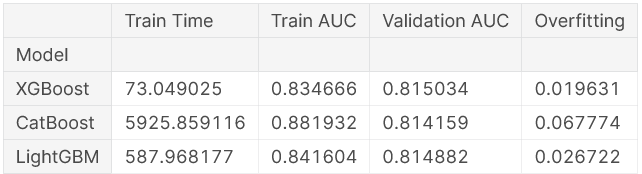

Now, let us look at how we can train a simple Neural Network using tensorflow on this dataset.

<a id = "import-libraries"></a>
**4.0 Import Libraries**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

<a id = "model-structure"></a>
**4.1 Define Model Structure**

In [ ]:
nn = keras.Sequential([
    layers.BatchNormalization(input_shape = [X_train_final.shape[1]]),
    layers.Dense(units = 128, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.5),
    layers.Dense(units = 64, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.4),
    layers.Dense(units = 32, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),
    layers.Dense(units = 1, activation = 'sigmoid')
])

This structure was decided upon after training different structures on the train set and analyzing the performances. Most of the times, this back & forth process of defining a structure then evaluating performance is an integral part of training a neural network.

- **Dropout:** Dropout leaves out some nodes (or activation units) from the previous layer. Dropout is random, i.e. differnt nodes will be shut off for different iterations. Doing this introduces some noise into the current layer evaluations and thus, it helps to preven overfitting of the training set.
- Applying *BatchNormalization()* to every layer helps by harmonizing the different features to a common scale of values. This helps in training speed-up for out learning algorithm.
- We use the sigmoid activation function at the output layer since we need probabilities.

<a id = "model-compilation"></a>
**4.2 Model Compilation**

- Here, we will define the type of optimizer we will use for our gradient descent algorithm. *Adam()* is almost always a good choice as it combines the advantages of both *RMSProp* and *SGD* which implements momentum. 
- For the loss function, binary cross-entropy is a good choice since we're working with probabilities.
- AUC-ROC score is a good evaluation metric when working with probabilistic outputs.

In [ ]:
auc = keras.metrics.AUC(name = 'auc')
nn.compile(optimizer = keras.optimizers.Adam(learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = 9000, decay_rate = 0.9)),
             loss = 'binary_crossentropy',
             metrics = [auc])

<a id = "pruning"></a>
**4.3 Pruning**

Early-Stopping is when we pre-maturely stop the training of a model when a certain monitored metric has stopped improving. 

For more on EarlyStopping, check out the tensorflow documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20,
                                min_delta = 0.001,
                                restore_best_weights = False)

<a id = "train-model"></a>
**4.4 Train Model**

With everything in line, we can now train our neural network. 

- We want to use mini-batch gradient descent algorithm, and for that the argument *batch_size* will be set to a certain number(256 in this case).
- 1 epoch means 1 iteration over the entire training set. Setting *epochs = 100* means we want to iterate over the training set 100 times, with each step of gradient descnet training on 256 training examples because of the *batch_size* setting.

In [ ]:
history = nn.fit(X_train_final, Y_train_orig,
                   validation_data = (X_valid_final,Y_valid_orig),
                   batch_size = 256,
                   epochs = 100,
                   callbacks = [early_stopping])

<a id = "review-performance"></a>
**4.5 Review Performance**

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot(title = 'Loss')
history_df.loc[:,['auc','val_auc']].plot(title = 'Dev')

We can clearly see that the validation loss and auc fluctuates as the training process continues. This is okay since are using mini-batch gradient descent. The fluctuations arise because different mini-batches can have varying distributions. The main idea is to analyze the general trend of the curve - it should go downwards. 

<a id = "submission"></a>
# **5. SUBMISSION**

Let's predict the claim variable for test set and submit our results!

In [ ]:
X_test_final.shape

In [ ]:
#prediction
preds = nn.predict(X_test_final)

#reshape distorted prediction array
preds = preds.reshape(len(X_test_final),)

preds[:10]

In [ ]:
output = pd.DataFrame({'id' : X_test_final.index,
                      'claim' : preds})
output.to_csv('submission.csv', index = False)

# **REFERENCES**

- Keras documentation -> [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras)

# THANK YOU FOR READING!